In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Convolution1D
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('Reviews.csv')
print("jumlah data ada : ",df.shape)

jumlah data ada :  (568454, 10)


In [3]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
df_filtered = df[df["Score"]!=3]
df_filtered.shape

(525814, 10)

In [5]:
df_filtered["Score"] = df_filtered["Score"].apply(lambda x : 1 if x>3 else 0)

In [6]:
sorted_data=df_filtered.sort_values('ProductId', kind='quicksort', na_position='last')

In [7]:
final_df=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final_df.shape

(364173, 10)

In [8]:
final_df=final_df[final_df["HelpfulnessNumerator"]<=final_df["HelpfulnessDenominator"]]

In [9]:
final_df['Score'].value_counts()

Score
1    307061
0     57110
Name: count, dtype: int64

In [10]:
def decontract(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

In [11]:
#set of custom stop words
stop_words= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
lemmatizer = WordNetLemmatizer()

In [13]:
def preprocess_text(review):
    review = re.sub(r"http\S+", "", review)             # removing website links
    review = BeautifulSoup(review, 'lxml').get_text()   # removing html tags
    review = decontract(review)                         # decontracting
    review = re.sub("\S*\d\S*", "", review).strip()     # removing the words with numeric digits
    review = re.sub('[^A-Za-z]+', ' ', review)          # removing non-word characters
    review = review.lower()                             # converting to lower case
    review = [word for word in review.split(" ") if not word in stop_words] # removing stop words
    review = [lemmatizer.lemmatize(token, "v") for token in review] #Lemmatization
    review = " ".join(review)
    review.strip()
    return review
final_df['Text'] = final_df['Text'].apply(lambda x: preprocess_text(x))

In [14]:
final_df['Text'].head()

150523    witty little book make son laugh loud recite c...
150505    grow read sendak book watch really rosie movie...
150506    fun way children learn months year learn poems...
150507    great little book read aloud nice rhythm well ...
150508    book poetry months year go month cute little p...
Name: Text, dtype: object

In [15]:
train_df, test_df = train_test_split(final_df, test_size = 0.20, random_state = 42)
print("Training data size : ", train_df.shape)
print("Test data size : ", test_df.shape)

Training data size :  (291336, 10)
Test data size :  (72835, 10)


In [16]:
top_words = 100000
tokenizer = Tokenizer(num_words=top_words, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['Text'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['Text'])
max_review_length = 500
X_train = pad_sequences(list_tokenized_train, maxlen=max_review_length)
y_train = train_df['Score']

In [18]:
embedding_vecor_length = 256
model = Sequential()
model.add(Embedding(top_words+1, embedding_vecor_length, input_length=max_review_length, trainable=False))
model.add(LSTM(100))
model.add(Dense(128, activation='gelu'))
model.add(Dense(64, activation='gelu'))
model.add(Dense(32, activation='gelu'))
model.add(Dense(1, activation='sigmoid'))
model.build(input_shape=(None, max_review_length))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 500, 256)       │    25,600,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │       142,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,766,353 (98.29 MB)

 Trainable params: 166,097 (648.82 KB)

 Non-trainable params: 25,600,256 (97.66 MB)

In [ ]:
history = model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.2)

Epoch 1/3
3642/3642 ━━━━━━━━━━━━━━━━━━━━ 2556s 701ms/step - accuracy: 0.8707 - loss: 0.3168 - val_accuracy: 0.8905 - val_loss: 0.2700
Epoch 2/3
2188/3642 ━━━━━━━━━━━━━━━━━━━━ 36:57 2s/step - accuracy: 0.8973 - loss: 0.2580

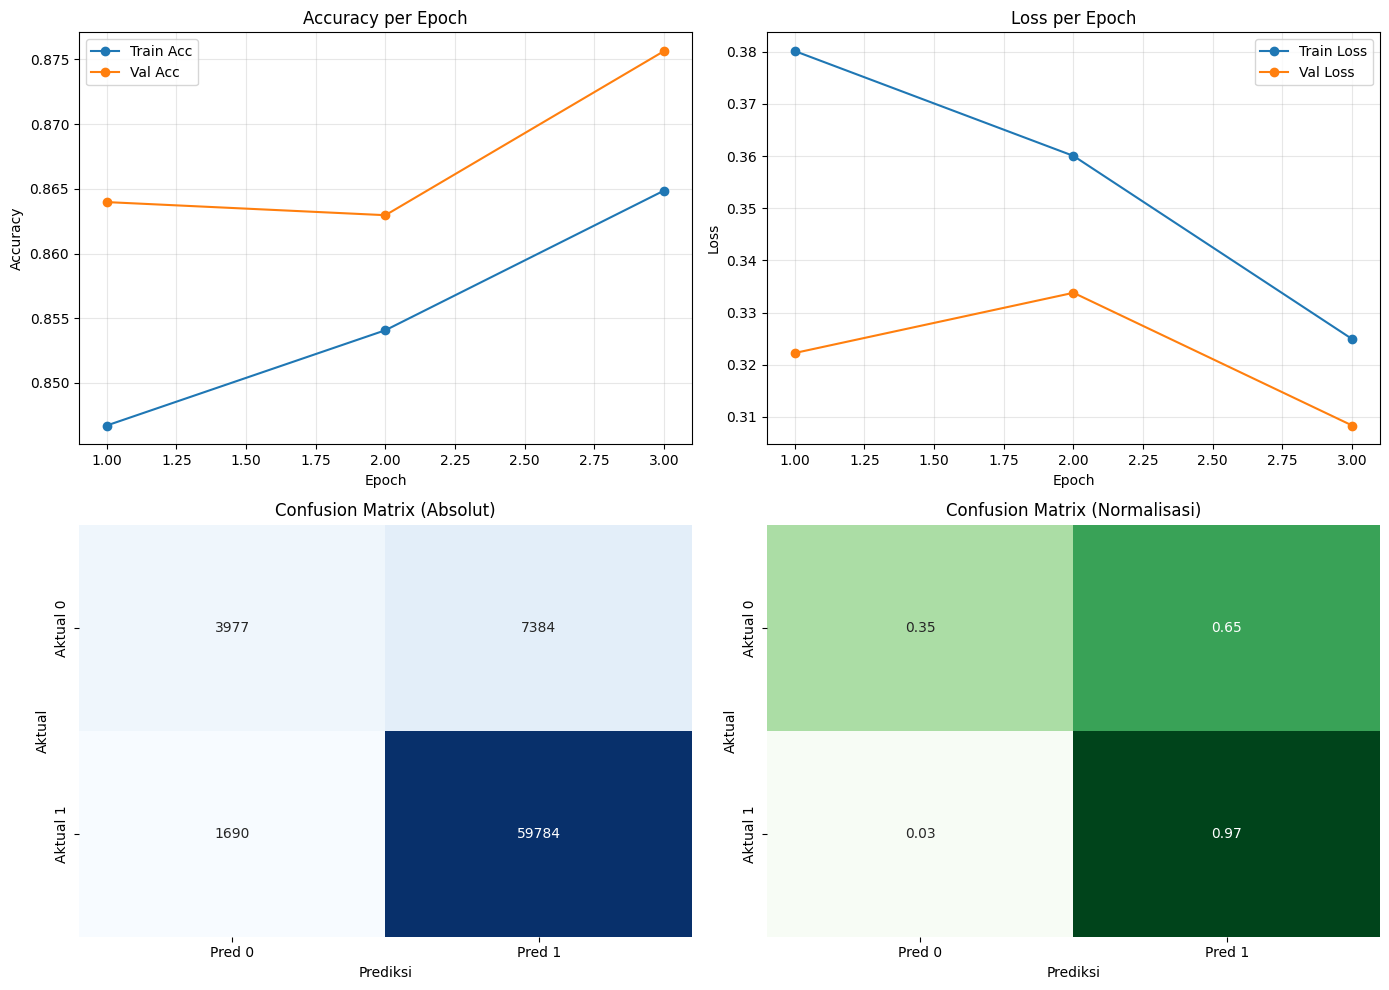

              precision    recall  f1-score   support

  Negatif(0)       0.70      0.35      0.47     11361
  Positif(1)       0.89      0.97      0.93     61474

    accuracy                           0.88     72835
   macro avg       0.80      0.66      0.70     72835
weighted avg       0.86      0.88      0.86     72835



In [24]:
# 1) Ambil history dari training sebelumnya
hist_obj = None
if 'history' in globals() and history is not None:
    hist_obj = history.history
elif hasattr(model, 'history') and hasattr(model.history, 'history'):
    hist_obj = model.history.history

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Accuracy
if hist_obj and (('accuracy' in hist_obj) or ('acc' in hist_obj)):
    train_acc = hist_obj.get('accuracy') or hist_obj.get('acc')
    val_acc = hist_obj.get('val_accuracy') or hist_obj.get('val_acc')
    epochs_range = range(1, len(train_acc) + 1)
    axes[0, 0].plot(epochs_range, train_acc, marker='o', label='Train Acc')
    if val_acc:
        axes[0, 0].plot(epochs_range, val_acc, marker='o', label='Val Acc')
    axes[0, 0].set_title('Accuracy per Epoch')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
else:
    axes[0, 0].axis('off')
    axes[0, 0].text(0.5, 0.5, 'History tidak tersedia. Simpan sebagai:\n history = model.fit(...)',
                    ha='center', va='center', fontsize=11)

# Plot Loss
if hist_obj and (('loss' in hist_obj)):
    train_loss = hist_obj.get('loss')
    val_loss = hist_obj.get('val_loss')
    epochs_range = range(1, len(train_loss) + 1)
    axes[0, 1].plot(epochs_range, train_loss, marker='o', label='Train Loss')
    if val_loss:
        axes[0, 1].plot(epochs_range, val_loss, marker='o', label='Val Loss')
    axes[0, 1].set_title('Loss per Epoch')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
else:
    axes[0, 1].axis('off')
    axes[0, 1].text(0.5, 0.5, 'History tidak tersedia. Simpan sebagai:\n history = model.fit(...)',
                    ha='center', va='center', fontsize=11)

# 2) Confusion Matrix menggunakan data uji tanpa retrain
# Jika X_test/y_test tidak tersedia, buat dari test_df seperti pada proses training
need_build_test = not (('X_test' in globals()) and ('y_test' in globals()))
if need_build_test:
    if 'test_df' in globals() and 'tokenizer' in globals():
        list_tokenized_test = tokenizer.texts_to_sequences(test_df['Text'])
        X_test = pad_sequences(list_tokenized_test, maxlen=max_review_length)
        y_test = test_df['Score'].values
    else:
        # Tidak bisa membangun confusion matrix tanpa data
        axes[1, 0].axis('off')
        axes[1, 1].axis('off')
        axes[1, 0].text(0.5, 0.5, 'Tidak ada X_test/y_test untuk Confusion Matrix',
                        ha='center', va='center', fontsize=11)
        axes[1, 1].text(0.5, 0.5, 'Pastikan test_df & tokenizer tersedia',
                        ha='center', va='center', fontsize=11)
        plt.tight_layout()
        plt.show()
        raise SystemExit

# Prediksi dan hitung CM
y_prob = model.predict(X_test, verbose=0).ravel()
y_pred = (y_prob >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot CM Absolut
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Aktual 0', 'Aktual 1'], ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix (Absolut)')
axes[1, 0].set_xlabel('Prediksi')
axes[1, 0].set_ylabel('Aktual')

# Plot CM Normalisasi
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens', cbar=False,
            xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Aktual 0', 'Aktual 1'], ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix (Normalisasi)')
axes[1, 1].set_xlabel('Prediksi')
axes[1, 1].set_ylabel('Aktual')

plt.tight_layout()
plt.show()

print(classification_report(y_test, y_pred, target_names=['Negatif(0)', 'Positif(1)']))